### imports

In [1]:
import numpy as np
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')


### Function for reading the csv files and dropping the unwanted columns

In [2]:
cols_to_drop = ['id', 'uri', 'duration_ms']

def read_csv_files(file_name, cols_to_drop=cols_to_drop): 
    df = pd.read_csv(file_name, index_col=0)
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    labels = df['label']
    
    # This makes the categorical labels numbers. Print it to see...
    y = labels.factorize()[0]
    
    return df, y

df, y = read_csv_files("..\data\csvs\dataframeV1.csv")

df.tail(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,label
40,0.547,0.568,0,-8.878,0,0.1970,0.63600,0.000000,0.2430,0.265,92.151,4,rap
41,0.647,0.612,4,-7.442,0,0.0681,0.08710,0.000000,0.2940,0.615,145.055,4,rap
42,0.824,0.624,5,-7.485,0,0.0793,0.00919,0.014700,0.1070,0.695,160.084,4,rap
43,0.528,0.705,4,-7.300,0,0.1560,0.28000,0.000000,0.0876,0.485,141.280,4,rap
44,0.846,0.546,0,-10.145,1,0.3300,0.20500,0.000004,0.3270,0.710,137.941,4,rap
45,0.651,0.761,10,-7.801,1,0.2500,0.44600,0.000035,0.1110,0.869,139.526,4,rap
46,0.871,0.639,7,-7.821,1,0.3490,0.12100,0.000000,0.1930,0.764,141.060,4,rap
47,0.617,0.477,1,-9.889,1,0.3600,0.00422,0.000000,0.0830,0.436,99.095,4,rap
48,0.850,0.564,1,-9.631,0,0.3830,0.23800,0.000000,0.1110,0.348,139.920,4,rap
49,0.736,0.518,10,-11.607,0,0.4680,0.37900,0.000000,0.0989,0.771,142.079,4,rap


### Standardize the data

We can drop the labels of our training data and then convert them on a single scale. We can standardize the values using the below formula.

$$x_i = \frac{{x}_i - mean(x)} {\sigma(x)} $$

It’s recommended to standardize the data to have a mean of zero and a standard deviation of one since almost always the features in any dataset would have different units of measurements such as age vs income.

In [3]:
X = df.drop(["label"], axis=1)

def standardise(X):
    # mean and standard deviation of all the features irrespective of class differences
    mean_all   = X.mean()  
    std_all    = X.std() 

    # standardised values
    X_standardised = (X-mean_all)/std_all
    return X_standardised

X_standardised = standardise(X)
X_standardised.head(10)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,-1.100925,-1.050292,0.511531,-0.834979,0.903018,-0.373430,1.090495,1.715003,0.113724,-0.370043,-1.362347,0.252684
1,-1.368146,-1.141622,-1.470268,-1.661467,0.903018,-0.563558,1.329736,1.869971,-0.530812,-0.735956,0.579970,0.252684
2,-1.031645,-1.422685,1.077759,-2.325506,-1.106597,-0.564564,1.324903,1.909417,-0.530812,-1.143451,0.321814,-1.850984
3,-2.089151,-1.306607,-0.904040,-1.889913,0.903018,-0.570600,1.158159,2.010851,-0.193198,-1.374226,-1.152733,0.252684
4,-1.818465,-1.047346,-0.904040,-0.510575,0.903018,-0.661137,0.747340,1.946046,-0.546158,-1.219128,-0.984384,0.252684
5,-1.997108,-1.413846,-0.904040,-1.489855,-1.106597,-0.403609,1.179908,1.681192,-0.581454,-1.419549,-1.553228,-1.850984
6,-0.601121,-1.495779,-0.054697,-2.427656,-1.106597,-0.433788,1.346652,2.002398,-0.636700,-1.480673,-1.409408,0.252684
7,-1.625471,-1.465404,1.077759,-2.355718,-1.106597,-0.568588,1.322486,1.765720,-0.695783,-1.395848,0.403349,-1.850984
8,-0.804011,-1.498077,-1.187154,-2.644462,0.903018,-0.559534,1.339402,1.931958,-0.839269,-1.474852,0.530238,-1.850984
9,-1.447323,-1.310731,-0.337811,-1.412345,-1.106597,-0.548469,1.049413,0.475261,-0.615983,-1.484831,-0.799362,-6.058321


### Plot the Confusion Matrix and print the Classification Report and Accuracy Score

In [4]:
labels = ["Classic", "Jazz", "Metal", "Rap"]

def confusion_matrix_score(ytest, ypred, labels=labels):
    
    score = accuracy_score(ytest, ypred) * 100
    print(f"The accuracy score is {score:.2f}%.", end="\n\n")
    
    conf_matrix = confusion_matrix(ytest, ypred)

    sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=True, lw=0.6,
                xticklabels=labels,
                yticklabels=labels)

    plt.title("Confusion Matrix", color="blue", fontsize=25)

    plt.xlabel('True Label')
    plt.ylabel('Predicted Label');

    # classification_report
    print(f"classification_report: \n{ classification_report(ytest, ypred, target_names=labels) }", end="\n\n")
    

### Explanation of k-means and k-means++

Clustering is one of the most common exploratory data analysis technique used to get an intuition about the structure of the data. It can be defined as the task of identifying subgroups in the data such that data points in the same subgroup (cluster) are very similar while data points in different clusters are very different. In other words, we try to find homogeneous subgroups within the data such that data points in each cluster are as similar as possible according to a similarity measure such as euclidean-based distance or correlation-based distance. The decision of which similarity measure to use is application-specific.

Clustering is used in market segmentation; where we try to find customers that are similar to each other whether in terms of behaviors or attributes, image segmentation/compression; where we try to group similar regions together, document clustering based on topics, etc. In our case, clustering based on music genre of either being "Classic", "Jazz", "Metal" and "Rap". 

### Kmeans Algorithm
Kmeans algorithm is an iterative algorithm that tries to partition the dataset into "K" pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.

That is, K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion:

$$\sum_{i=0}^n \underset{\mu_j \in \mathbf{C}}{\text{min}}(||x_i - \mu_j||^2)$$
Inertia can be recognized as a measure of how internally coherent clusters are

The way kmeans algorithm works is as follows:

1. Specify number of clusters K.
2. Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement.
3. Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn’t changing.
    - Compute the sum of the squared distance between data points and all centroids.
    - Assign each data point to the closest cluster (centroid).
    - Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.

The approach kmeans follows to solve the problem is called Expectation-Maximization. 
1. The E-step is assigning the data points to the closest cluster. 
2. The M-step is computing the centroid of each cluster.

K-means itself is NP-HARD. But there are approximation algorithms that converge to a local minimum, one of which is the Lloyd's algorithm which we will use for this section of the project; though we will implement the k-means++ with a smart initialization of all the centroids as would be seen in later sections below.

#### Lloyd's Algorithm for k-means

- $\mu_1, \cdots, \mu_k \leftarrow$ randomly chosen centers
- **while** Objective function still improves **do** 
    - $S_i, \cdots, S_k \leftarrow \phi$
    - **for** i $\in$ 1,..., N **do**
        - j $\leftarrow \text{argmin}_j ||x_i - \mu_j||^2$
        - add i to $S_j$
    - **end for**
    - **for** j $\in$ 1,...,k **do**
        - $\mu_j = \frac{1}{|S_j|} \sum_{i \in S_j} x_i$
    - **end for**
- **end while**



#### k-means++

This algorithm ensures a smarter initialization of the centroids and "improves" the quality of the clustering. (Really? We shall elaborate on this later.) Apart from initialization, the rest of the algorithm is the same as the standard K-means algorithm. That is K-means++ is the standard K-means algorithm coupled with a smarter initialization of the centroids.
 
Still sensitive to outliers as we shall explain in a later section.

**Initialisation**

- C $\leftarrow \text{sample a point uniformly from } \mathbf{X} $
- **while** |C| < k **do**
    - sample x $\in \mathbf{X} \text{ with probability proportional to } d^2 (x,C), \\
     \text{where d(x,C) is the distance between x and centroid C }$
    - C $\leftarrow \cup \space{} \{x\}$
- **end while**

The algorithm in plain english

1. Choose one center uniformly at random among the data points.
2. For each data point x not chosen yet, compute D(x), the distance between x and the nearest center that has already been chosen.
3. Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to $D(x)^2$.
4. Repeat Steps 2 and 3 until k centers have been chosen.
5. Now that the initial centers have been chosen, proceed using standard k-means clustering.

### Class implementation of the k-means++ algorithm

In [5]:
class KMeans_plus_plus:
    def __init__(self, K=4, init="kmeans++", rand_seed=None):
        self.K = K
        self.init = init
        self.rand_seed = rand_seed
    
        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []

    ##########################################################################################
    # initialization algorithm
    def __initialize_centroids_further_first(self):
        
        centroids = list( self.__random_centroid(how_many_centroids=1) )
    
        ## compute the remaining k - 1 centroids
        for _ in range(self.K - 1):
            next_cent_id = self.__max_arg(centroids)
            centroids.append(self.X[next_cent_id, :])
        return np.array(centroids)

    
    def __plus_plus_init(self):
        # (K, d) 
        centroids = np.zeros((self.K, self.X.shape[1]), dtype=np.float32)
        # First centroid | note randint sample from discrete uniform
        centroids[0,:] = self.X[np.random.randint(low = 0, high = self.X.shape[0], size = 1), : ]

        for k in range (1, self.K) : 
            # Calculate the distance to the closest centroid for each point
            d = np.asarray([self.__min_dist(point, centroids[:k,:]) for point in self.X])
            d_sum = np.sum(d)

            # Turn the distance into probabilities that sums up to one
            d /= d_sum
        
            # sample with distance as weight the new centroid
            centroids[k, :] = self.X[np.random.choice(self.X.shape[0], p=d),:]

        return centroids         
    
    def __max_arg(self, centroids):
        return np.argmax([ self.__min_dist(point,centroids ) for point in self.X])
        
    def __min_dist(self, point, centroids):
        return min( [ self.euclidean_distance(point, centroid) for centroid in centroids] ) 
    
    ##########################################################################################
    # get the how_many_centroids "centroids". 1 if k-means++, but k if k-means
    def __random_centroid(self, how_many_centroids):
        self.__set_seed() 
        l = self.X.shape[0]
        choices = np.random.choice(l, how_many_centroids)
        return np.array(self.X[choices, :])
    
    # set the random seed for reproducibility
    def __set_seed(self):
        if self.rand_seed is not None and isinstance(self.rand_seed, int):
            np.random.seed(self.rand_seed)
    ##########################################################################################
    def fit_predict(self, X):
        self.X = X
        # print(self.X.shape)
        self.n_samples, self.n_features = X.shape


        if self.init == 'further_first': 
            self.centroids = self.__initialize_centroids_further_first()
        elif self.init is None: 
            self.centroids = self.__random_centroid(how_many_centroids=self.K)
        # Kmean ++
        else: 
            self.centroids = self.__plus_plus_init()

        
                    
        #Initialize an empty array to compare with current centroids to see if convergence occurs...
        i, j = self.centroids.shape
        centroids_old = np.zeros(shape=(i, j) )

        #if the current centroids are the same as the previous centroids, then stop
        while not self.__has_converged(centroids_old, self.centroids) :
            
            # Assign samples to closest centroids (create clusters)
            self.clusters = self.__create_clusters(self.centroids)

            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self.__centroids_means_of_clusters(self.clusters)

        # Classify samples as the index of their clusters
        return self.__get_cluster_labels(self.clusters)

    # each sample will get the label of the cluster it was assigned to
    def __get_cluster_labels(self, clusters):
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            labels[cluster] = cluster_idx
        return labels
    
    # Assign the samples to the closest centroids to create clusters; Expectation step
    def __create_clusters(self, centroids):
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self.__closest_centroid_label(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters
    
    # arg that minimizes the distance of the current sample to each centroid
    def __closest_centroid_label(self, point, centroids):
        return np.argmin( [ self.euclidean_distance(point, centroid) for centroid in centroids] ) 

    # assign mean value of clusters to centroids; Maximisation step
    def __centroids_means_of_clusters(self, clusters):
        return [ np.mean(self.X[cluster], axis=0) for cluster in clusters]
        
    # distances between each old and new centroids
    def __has_converged(self, old_centroids, current_centroids):
        distances = [self.euclidean_distance(old_centroids[i], current_centroids[i]) for i in range(self.K)]
        return sum(distances) == 0
    
    def euclidean_distance(self, point1, point2):
        dist = la.norm(point1 - point2)
        return np.square(dist)


The accuracy score is 85.96%.

classification_report: 
              precision    recall  f1-score   support

     Classic       0.77      0.91      0.83       244
        Jazz       0.90      0.78      0.84       382
       Metal       0.82      0.98      0.89       406
         Rap       0.97      0.77      0.86       350

    accuracy                           0.86      1382
   macro avg       0.87      0.86      0.86      1382
weighted avg       0.87      0.86      0.86      1382




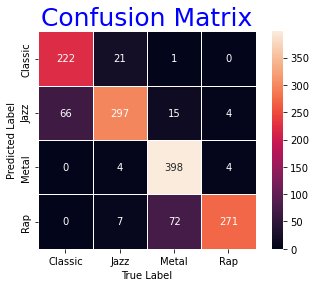

In [6]:
#Our own implementation

#k = KMeans_plus_plus(K=4, init="k-means", rand_seed=4)
k = KMeans_plus_plus(K=4, init="kmeans++", rand_seed=4)   
y_pred = k.fit_predict(X_standardised.values).astype(np.uint8)

confusion_matrix_score(y, y_pred)

#print(accuracy_score(y, y_pred))

# for i in list(zip(y, y_pred)):
#     print(i, end="  ")
    

The accuracy score is 85.96%.

classification_report: 
              precision    recall  f1-score   support

     Classic       0.77      0.92      0.84       244
        Jazz       0.91      0.78      0.84       382
       Metal       0.82      0.98      0.89       406
         Rap       0.97      0.77      0.86       350

    accuracy                           0.86      1382
   macro avg       0.87      0.86      0.86      1382
weighted avg       0.87      0.86      0.86      1382




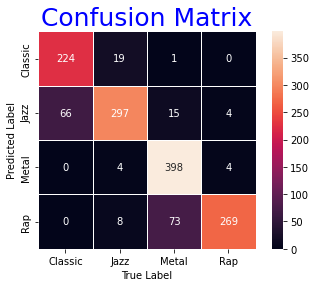

In [13]:

# sk-learn
km = KMeans(n_clusters=4, init="k-means++")

y_pred_2 = km.fit_predict(X_standardised)

confusion_matrix_score(y, y_pred_2)

# for i in list(zip(y, y_pred_2)):
#     print(i, end="  ")
    

### Clustering performance evaluation

Evaluating the performance of a clustering algorithm is not as trivial as counting the number of errors or the precision and recall of a supervised classification algorithm. In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar than members of different classes according to some similarity metric.

how can one measure clustering goodness of fit? Supervised algorithms have lots of metrics to check their goodness of fit like accuracy, r-square value, sensitivity, specificity etc. but what can we calculate to measure the accuracy or goodness of our clustering technique? The answer to this question is Silhouette Coefficient or Silhouette score.

We can also use the silhouette score to check the optimal number of clusters.

[**Silhouette Coefficient**](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)  
Silhouette score for a set of sample data points is used to measure how dense and well-separated the clusters are.  
If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:  
- a: The mean distance between a sample and all other points in the same class.
- b: The mean distance between a sample and all other points in the next nearest cluster.


The Silhouette Coefficient, s, for a single sample is then given as:

$$s = \frac{b-a}{max(a,b)}$$

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

**Advantages**
- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

**Drawbacks**
- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [8]:

def silhouette_score(X, y, centroids):
    list_1 = []
    closest_cents = nearest_cluster(centroids, centroids)
    
    #for each cluster and its closest cluster, do
    for i, val in enumerate(closest_cents):
        print(f"Label {i} is closest to label {val}")
        
        x    = X[y==i, :]
        cent = X[y==val, :]
        
        d = sample_score(x, cent)
        list_1.extend(d)
                
    l = X.shape[0]
    return sum(list_1)/l
    

def nearest_cluster(centroids1, centroids2):
    closest_cents = []
    for val1 in centroids1 :
        list_dist = [k.euclidean_distance(val1, val2) for val2 in centroids2]
        
        #dist btw a cent and itself is 0 (minimum), but we are interested in min dist btw different centroids
        #That is, we are interested in the second min dist
        second_min_dist = np.argsort(list_dist)[1] #sorted(range(len(list_dist)), key=lambda i: list_dist[i])[1]
        
        closest_cents.append(second_min_dist)
        
    return closest_cents
    
#Array of distances btw data points
def sample_score(X1, X2):
    
    l1 = X1.shape[0] - 1  #-1 for excluding the data point itself
    l2 = X2.shape[0]
    list_sum = []
    
    for val1 in X1:
        a = get_dist(val1, X1)/l1 #for any other in-cluster data point excluding val1 itself...
        b = get_dist(val1, X2)/l2 #for all data points in the closest cluster...
        m = max(a, b)
        
        s = (b-a)/m
        list_sum.append(s)
    return list_sum

#Dist btw a single data point and all the rest
def get_dist(val1, X2):
    sum_for_single_data_point = sum( [k.euclidean_distance(val1, val2) for val2 in X2] )
    return sum_for_single_data_point
    
    
silh_score = silhouette_score(X_standardised.values, y_pred, k.centroids)
silh_score


Label 0 is closest to label 2
Label 1 is closest to label 2
Label 2 is closest to label 1
Label 3 is closest to label 0


0.2871164553525391

##### sk-learn silhouette_score

In [9]:
from sklearn.metrics import silhouette_score as sls

sls(X = X_standardised.values, metric="euclidean", labels=y_pred_2 )

0.1766545263206541

### One may wonder whether or not kmeans++ always does a better job in clustering than kmeans. The answer is that kmeans++ does not always outperform kmeans. A plot would help to better understand. So let's see some plots below.

In [10]:
np.random.seed(0)

x1 = np.random.uniform(low=1, high=10, size=50)
y1 = np.random.uniform(low=1, high=3, size=50)

x2 = np.random.uniform(low=15, high=25, size=50)
y2 = np.random.uniform(low=6, high=9, size=50)

x_outlier = np.random.uniform(low=-20,high=-3, size=2)
y_outlier = np.random.uniform(low=-30,high=-3, size=2)

xs = np.concatenate([x1, x2, x_outlier], axis=0)
ys = np.concatenate([y1, y2, y_outlier], axis=0)


In [11]:
dat = pd.DataFrame(list(zip(xs, ys)), columns = ["X1", "X2"])
dat.head(10)

,X1,X2
0,5.939322,2.140394
1,7.436704,1.877203
2,6.424870,2.976748
3,5.903949,1.204090
4,4.812893,1.417754
5,6.813047,1.322619
6,4.938285,2.306217
7,9.025957,1.506583
8,9.672965,1.932622
9,4.450974,1.488851


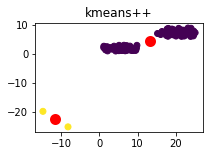

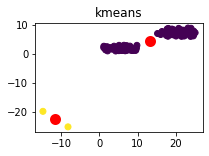

In [12]:

#change the init="kmeans++" to any other string to see how kmeans bits kmeans++ for this toy example
def testing_inits(k=2, init="kmeans++", rand_seed=4):
    k_toy = KMeans_plus_plus(K=k, init=init, rand_seed=rand_seed) #set k = 2, 3 and seed = 4 and 0 to see...

    pred_k_toy = k_toy.fit_predict(dat.values)

    k_toy.centroids = np.array(k_toy.centroids)

    if not init == "kmeans++": init = "kmeans"
    
    plt.figure(figsize=(3,2))
    plt.scatter(dat["X1"], dat["X2"], c=pred_k_toy)
    
    plt.scatter(k_toy.centroids[:, 0], k_toy.centroids[:, 1], marker = "o", linewidths=5, c="red")
    plt.title(init)
    plt.show()

#pred_k_toy, k_toy.centroids#, k_toy.clusters

k_p = testing_inits(k=2, init="kmeans++", rand_seed=4)
k1 = testing_inits(k=2, init="kmeans", rand_seed=4)


From this toy example, when k=2, kmeans clusters the data better. However, for other k values, either kmeans++ outperforms it or they are on a par with each other. Therefore, We can conclude that kmeans++ is sensitive to outliers and does not always outperform kmeans